# Analyse fréquentielle intégratrice

## Activité de transfert - 21 juillet 2022

préparée par :
- Duy Anh Alexandre
- Gabriel Gobeil
- Jonathan Jalbert

## Partie 4 : Post-traitement des simulations  pour l'analyse fréquentielle des débits projetés

Les débits simulés des ensembles hydroclimatiques et analysés à la partie 3 ne sont pas à la même échelle que les débits des pseudo-observations. Une méthode de post-traitement décrite au chapitre 7 du mémoire de Duy Anh est utilisée.

Dans un premier temps, les résultats des parties 2 et 3 seront chargés, soit respectivement les résultats pour les pseudo-observations et les simulations hydroclimatiques pour le même tronçon. Ensuite, la méthode de post-traitement adapatée de Kallache *et al.* (2011) sera appliquée. Enfin, l'analyse fréquentielle des débits futurs sera effectuée


####  Table des matières
1. [Chargement des librairies et des fonctions utiles](#preparation)
2. [Chargement des données](#data)
    1. [Chargement du modèle pour les pseudo-observations](#data1)
    2. [Chargement du modèle pour les simulations hydroclimatiques](#data2)
4. [Post-traitement statistique selon Kallache *et al.* (2011)](#postprocessing)
5. [Résultats](#resultats)
    1. [Fonctions de répartition futures](#cdf)
    2. [Affichage de la jonctions des modèles](#figures)

---
# 1. Chargement des librairies et des fonctions utiles <a name="preparation"></a>

In [1]:
# Chargement des librairies
using CSV, DataFrames, Dates, NetCDF
using Distributions, Extremes
using Mamba
using Gadfly
using ProgressMeter, StatsBase

using ErrorsInVariablesExtremes

using Serialization

In [2]:
include("../3-SimulationFrequencyAnalysis/3-utils.jl")
include("../3-SimulationFrequencyAnalysis/3-hierarchicalbayesmodel.jl")
include("../3-SimulationFrequencyAnalysis/3-hierarchicalbayeseva.jl")
include("4-utils.jl");

---
# 2. Chargement des résultats <a name="data"></a>

Les modèles ajustés des parties 2 et 3 sont chargés avec la fonction `deserialize` de la librairie Julia de base `Serialization`.

## 2.1 Chargement du modèle pour les pseudo-observations <a name="data1"></a>

In [3]:
fm_obs = deserialize("../2-PseudoObservationsFrequencyAnalysis/2-Results/ModelObs.txt")

PseudoMaximaEVA
   model: PseudoMaximaModel
   maxima:
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,60,1]
   parameters:
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,3,1]


## 2.2 Chargement du modèle pour les simulations hydroclimatiques <a name="data2"></a>

In [4]:
fm_sim = deserialize("../3-SimulationFrequencyAnalysis/3-Results/ModelSim.txt")

HierarchicalBayesEVA
   model: HierarchicalBayesModel
   hyperparameters :
		Mamba.Chains
		Iterations :		10000:20000
		Thinning interval :	10
		Chains :		1
		Samples per chain :	1001
		Value :			Array{Float64, 3}[1001,6,1]
   fittedmodels :		Vector{BayesianEVA{BlockMaxima}}[48]



## 2.3 Affichage des deux modèles

In [5]:
# Conversion des pseudo-obs dans un DataFrame

df_obs = DataFrame(Year = getyears(fm_obs)[1], 
    Value = vec(mean(fm_obs.maxima.value, dims=1)),
    Source = "Pseudo Obs");

In [6]:
# Conversion des simulations dans un DataFrame

df_sim = DataFrame(Year = Int64[], Value = Float64[])

years_sim = collect(1955:1:2099);

for fm in fm_sim.fittedmodels
   append!(df_sim, DataFrame(Year = years_sim, Value = fm.model.data.value)) 
end

df_sim[:,:Source] .= "Sim";

In [7]:
# Concaténation dans un seul DataFrame
df = vcat(df_obs, df_sim)
first(df, 5)

5×3 DataFrame
 Row │ Year   Value    Source     
     │ Int64  Float64  String     
─────┼────────────────────────────
   1 │  1961  836.9    Pseudo Obs
   2 │  1962  766.956  Pseudo Obs
   3 │  1963  882.966  Pseudo Obs
   4 │  1964  914.801  Pseudo Obs
   5 │  1965  637.21   Pseudo Obs

In [8]:
# Affichage des pseudo-obs et des simulations

Gadfly.set_default_plot_size(12cm, 8cm)
plot(df, x=:Year, y=:Value, color=:Source, Geom.point)

---
# 3. Post-traitement <a name="postprocessing"></a>

La distribution des débits simulés (points jaunes) est mise à l'échelle de la distribution des pseudo-observations (points bleus). 

Dans la méthode de post-traitement développée, une année de référence doit être choisie. Ici, on choisit la dernière années des pseudo observation, soit l'année 2020.

La fonction `postprocess` effectue le post-traitement des simulations. Elle prend en entrée :
- le modèle ajusté pour les pseudo-observations ;
- le modèle ajusté pour les simulations ;
- l'année de référence.

La fonction retourne une matrice de distributions GEV modélisant les débits sur toute la période de simulation.

In [9]:
new_dist = postprocess(fm_obs, fm_sim, 2020)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


1001×145×48 Array{GeneralizedExtremeValue{Float64}, 3}:
[:, :, 1] =
 GeneralizedExtremeValue{Float64}(μ=777.535, σ=203.034, ξ=-0.139094)    …  GeneralizedExtremeValue{Float64}(μ=777.535, σ=203.034, ξ=-0.139094)
 GeneralizedExtremeValue{Float64}(μ=817.001, σ=210.096, ξ=-0.0563199)      GeneralizedExtremeValue{Float64}(μ=817.001, σ=210.096, ξ=-0.0563199)
 GeneralizedExtremeValue{Float64}(μ=780.547, σ=189.854, ξ=-0.0513534)      GeneralizedExtremeValue{Float64}(μ=780.547, σ=189.854, ξ=-0.0513534)
 GeneralizedExtremeValue{Float64}(μ=860.474, σ=305.593, ξ=-0.216525)       GeneralizedExtremeValue{Float64}(μ=860.474, σ=305.593, ξ=-0.216525)
 GeneralizedExtremeValue{Float64}(μ=930.549, σ=283.326, ξ=-0.155485)       GeneralizedExtremeValue{Float64}(μ=930.549, σ=283.326, ξ=-0.155485)
 GeneralizedExtremeValue{Float64}(μ=828.521, σ=213.172, ξ=0.0782127)    …  GeneralizedExtremeValue{Float64}(μ=828.521, σ=213.172, ξ=0.0782127)
 GeneralizedExtremeValue{Float64}(μ=756.074, σ=195.817, ξ=-0.0855889)   

Dans cet exemple, la fonction retourne une matrice de dimension $(1001 \times 145 \times 48)$ de distributions GEV, soit une GEV post-traitée pour chacune des 1001 itérations MCMC, des 145 années et pour chacun des 48 membre de l'ensemble des simulations hydroclimatiques.

---
# 4. Résultats <a name="resultats"></a>

## 4.1 Affichage de la tendance post-traitée

Avec les pseudo-observations en filigrane



In [10]:
# Extraction de la moyenne et des intervalles de confiance dans un DataFrame

df = DataFrame(Year = Int64[], Discharge = Float64[], ymin = Float64[], ymax = Float64[])

years_sim = collect(1955:1:2099)

for i in 1:size(new_dist, 2)
    push!(df, 
        [years_sim[i], mean(mean.(new_dist[:,i,:])), mean(quantile.(new_dist[:,i,:], .025)), mean(quantile.(new_dist[:,i,:], .95))])
end

first(df, 5)

5×4 DataFrame
 Row │ Year   Discharge  ymin     ymax    
     │ Int64  Float64    Float64  Float64 
─────┼────────────────────────────────────
   1 │  1955    911.265  568.224   1306.7
   2 │  1956    911.265  568.224   1306.7
   3 │  1957    911.265  568.224   1306.7
   4 │  1958    911.265  568.224   1306.7
   5 │  1959    911.265  568.224   1306.7

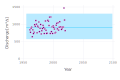

In [11]:
# Affichage des séries

fig_sim = layer(df, x=:Year, y=:Discharge, Geom.line,
            ymin=:ymin, ymax=:ymax, Geom.ribbon)

years_obs = getyears(fm_obs)[1];

# Maxima annuels des pseudo-observations
ȳ_obs = mean(fm_obs.maxima.value, dims=1)

fig_obs = layer(x=years_obs, y=ȳ_obs, Geom.point, Theme(default_color="purple"))

plot(fig_obs,fig_sim,
    Guide.xlabel("Year"), Guide.ylabel("Discharge [m³/s]"))

## 4.2 Calculs des quantiles effectifs post-traités

### Calcul sur la période d'observation

In [12]:
T = 20

df_obs = DataFrame(Year = Int64[], ReturnLevel = Float64[], ymin = Float64[], ymax = Float64[])

pd = vec(ErrorsInVariablesExtremes.getdistribution(fm_obs))

for iyear in 1961:2020
    
    q = quantile.(pd, 1-1/T)
    
    push!(df_obs, [iyear, mean(q), quantile(q, .025), quantile(q, .975)])
    
end

first(df_obs, 5)

5×4 DataFrame
 Row │ Year   ReturnLevel  ymin     ymax    
     │ Int64  Float64      Float64  Float64 
─────┼──────────────────────────────────────
   1 │  1961       1306.7  1145.68  1541.27
   2 │  1962       1306.7  1145.68  1541.27
   3 │  1963       1306.7  1145.68  1541.27
   4 │  1964       1306.7  1145.68  1541.27
   5 │  1965       1306.7  1145.68  1541.27

### Calcul sur la période future

In [13]:
years_sim = collect(1955:1:2099);

df_sim = DataFrame(Year = Int64[], ReturnLevel = Float64[], ymin = Float64[], ymax = Float64[])

for j in eachindex(years_sim)
    
    q = vec(quantile.(new_dist[:,j,:], 1-1/T))
    
    push!(df_sim, [years_sim[j], mean(q), quantile(q, .025), quantile(q, .975)])
    
end

first(df_sim, 5)

5×4 DataFrame
 Row │ Year   ReturnLevel  ymin     ymax    
     │ Int64  Float64      Float64  Float64 
─────┼──────────────────────────────────────
   1 │  1955       1306.7  1145.68  1541.27
   2 │  1956       1306.7  1145.68  1541.27
   3 │  1957       1306.7  1145.68  1541.27
   4 │  1958       1306.7  1145.68  1541.27
   5 │  1959       1306.7  1145.68  1541.27

### Affichage des quantiles effectifs

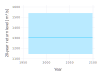

In [14]:
df = append!(df_obs, filter(row -> row.Year > 2020, df_sim))

Gadfly.set_default_plot_size(10cm, 8cm)
plot(df, x=:Year, y=:ReturnLevel, Geom.line,
    ymin=:ymin, ymax=:ymax, Geom.ribbon,
    Guide.ylabel(string(T,"-year return level [m³/s]")))